<a href="https://colab.research.google.com/github/lexiyutou/transformers-notebooks/blob/main/dfine_inference_seewiesen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference with D-Fine

In this notebook, we'll perform inference with the [D-Fine](https://huggingface.co/docs/transformers/main/model_doc/d_fine) object-detection model.

D-FINE is a powerful real-time object detector that redefines the bounding box regression task in DETRs as Fine-grained Distribution Refinement (FDR) and introduces Global Optimal Localization Self-Distillation (GO-LSD), achieving outstanding performance without introducing additional inference and training costs.


![](https://raw.githubusercontent.com/Peterande/storage/master/figs/stats_padded.png)

 - Paper: https://arxiv.org/abs/2410.13842

## Set-up environment

Let's start by upgrading 🤗 Transformers as the model is brand new at the time of writing.

In [ ]:
!pip install --upgrade pip uv
!pip install --upgrade git+https://github.com/huggingface/transformers
!uv pip install --upgrade numpy==1.*

# NOTE: you might need to restart your env to apply updates

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-uxw9eedo
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-uxw9eedo
  Resolved https://github.com/huggingface/transformers to commit 65f5fa71cd762c3c15ec9e4f836059cb8905da12
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using Python 3.11.12 environment at: /usr
Resolved 1 package in 73ms
Audited 1 package in 0.17ms


## Load model and image processor

We'll load an D-Fine checkpoint from the [hub](https://huggingface.co/ustc-community). Note that the authors have released 6 different checkpoints which leverage various settings. Here we load one that leverages a [HGNet-50](https://huggingface.co/docs/transformers/en/model_doc/hgnet_v2) backbone which has been trained on COCO dataset.

In [ ]:
import torch
from transformers import AutoImageProcessor, AutoModelForObjectDetection

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Pretrained on Object365 dataset first, then trained on COCO
checkpoint = "ustc-community/dfine-medium-obj365"

# Alternative checkpoints:
#   - https://huggingface.co/models?other=d_fine&author=ustc-community
#
# For example:
# checkpoint = "ustc-community/dfine-xlarge-obj365"
# checkpoint = "ustc-community/dfine-large-obj365"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForObjectDetection.from_pretrained(checkpoint).to(device)

Using device: cuda


## Load image

Next we'll load our image on which we'll perform inference.

In [ ]:
!rm /content/detected_images/*.jpg

In [ ]:

%cd /content/seewiesen_animal_images/

!rename 's/ /_/g' *

/content/seewiesen_animal_images


In [ ]:

import os
import json
from PIL import Image, ImageDraw
import torch
from transformers import AutoImageProcessor, AutoModelForObjectDetection, pipeline

# 设置设备
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 加载模型和处理器
checkpoint = "ustc-community/dfine-medium-obj365"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForObjectDetection.from_pretrained(checkpoint).to(device)
pipe = pipeline("object-detection", model=checkpoint, image_processor=checkpoint, device=device)

# 定义输入文件夹和输出文件夹
input_folder = "/content/seewiesen_animal_images/"
output_folder = "/content/detected_images/"
os.makedirs(output_folder, exist_ok=True)

# 初始化 COCO 格式的结构
coco_format = {
    "images": [],
    "annotations": [],
    "categories": []
}

# 定义类别映射
categories = model.config.id2label
for category_id, category_name in categories.items():
    coco_format["categories"].append({
        "id": category_id,
        "name": category_name
    })

# 遍历文件夹中的所有图像文件
annotation_id = 1  # COCO 格式的 annotation ID 从 1 开始
for image_id, filename in enumerate(os.listdir(input_folder), start=1):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join(input_folder, filename)
        print(f"Processing {image_path}...")

        # 加载图像
        image = Image.open(image_path)
        width, height = image.size

        # 添加图像信息到 COCO 格式
        coco_format["images"].append({
            "id": image_id,
            "file_name": filename,
            "width": width,
            "height": height
        })

        # 推理
        results = pipe(image, threshold=0.3)

        # 可视化结果并保存标记图像
        annotated_image = image.copy()
        draw = ImageDraw.Draw(annotated_image)
        for result in results:
            box = result["box"]
            category_name = result["label"]
            category_id = next((k for k, v in categories.items() if v == category_name), None)
            score = result["score"]

            # COCO 格式的边界框是 [x, y, width, height]
            bbox = [
                box["xmin"],
                box["ymin"],
                box["xmax"] - box["xmin"],
                box["ymax"] - box["ymin"]
            ]

            # 添加标注信息到 COCO 格式
            coco_format["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": bbox,
                "area": bbox[2] * bbox[3],  # 面积 = 宽 * 高
                "iscrowd": 0,
                "score": score
            })
            annotation_id += 1

            # 绘制边界框
            color = (255, 0, 0)  # 红色框
            draw.rectangle((box["xmin"], box["ymin"], box["xmax"], box["ymax"]), outline=color, width=2)
            draw.text((box["xmin"], box["ymin"]), text=f"{category_name} ({score:.2f})", fill=color)

        # 保存标记图像
        output_path = os.path.join(output_folder, filename)
        annotated_image.save(output_path)
        print(f"Saved annotated image to {output_path}")

# 保存 COCO 格式的 JSON 文件
coco_output_path = os.path.join(output_folder, "annotations.json")
with open(coco_output_path, "w") as f:
    json.dump(coco_format, f, indent=4)
print(f"Saved COCO annotations to {coco_output_path}")

Using device: cuda


Device set to use cuda


Processing /content/seewiesen_animal_images/MaG_FieldV5_axisQ8102_2025-03-07_21_39_03_956.jpg...
Saved annotated image to /content/detected_images/MaG_FieldV5_axisQ8102_2025-03-07_21_39_03_956.jpg
Processing /content/seewiesen_animal_images/MaG_FieldV5_axisQ8102_2025-05-29_17_54_36_575.jpg...
Saved annotated image to /content/detected_images/MaG_FieldV5_axisQ8102_2025-05-29_17_54_36_575.jpg
Processing /content/seewiesen_animal_images/MaG_FieldV5_axis8220_2025-03-03_17_50_13_734.jpg...
Saved annotated image to /content/detected_images/MaG_FieldV5_axis8220_2025-03-03_17_50_13_734.jpg
Processing /content/seewiesen_animal_images/MaG_FieldV5_axisQ8102_2025-05-05_03_01_41_551.jpg...
Saved annotated image to /content/detected_images/MaG_FieldV5_axisQ8102_2025-05-05_03_01_41_551.jpg
Processing /content/seewiesen_animal_images/MaG_FieldV5_axisQ8102_2025-05-05_02_33_53_798.jpg...
Saved annotated image to /content/detected_images/MaG_FieldV5_axisQ8102_2025-05-05_02_33_53_798.jpg
Processing /conte

In [ ]:
from PIL import Image
import requests
from IPython.display import display


# url = "https://live.staticflickr.com/65535/33021460783_1646d43c54_b.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open('/content/seewiesen_animal_images/MaG_FieldV5_axisQ8102_2025-02-25_19_33_15_946.jpg')
image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>

## Forward pass

The API is exactly the same as other object detection models in the Transformers library, which means that we first prepare the image for the model using the image processor, after which we forward the pixel values through the model in order to obtain class logits and predicted bounding boxes.

In [ ]:
inputs = image_processor(image, return_tensors="pt")
inputs = inputs.to(device)

print(inputs.keys())

KeysView({'pixel_values': tensor([[[[0.1686, 0.1490, 0.0941,  ..., 0.0078, 0.0039, 0.0039],
          [0.1922, 0.1765, 0.1294,  ..., 0.0039, 0.0078, 0.0039],
          [0.2000, 0.2196, 0.1961,  ..., 0.0039, 0.0000, 0.0039],
          ...,
          [0.2745, 0.2745, 0.3373,  ..., 0.4353, 0.3961, 0.3333],
          [0.2824, 0.2706, 0.2824,  ..., 0.4667, 0.4078, 0.3333],
          [0.3176, 0.2941, 0.2353,  ..., 0.4627, 0.5020, 0.4392]],

         [[0.1686, 0.1490, 0.0941,  ..., 0.0078, 0.0039, 0.0039],
          [0.1922, 0.1765, 0.1294,  ..., 0.0039, 0.0078, 0.0039],
          [0.2000, 0.2196, 0.1961,  ..., 0.0039, 0.0000, 0.0039],
          ...,
          [0.2745, 0.2745, 0.3373,  ..., 0.4353, 0.3961, 0.3333],
          [0.2824, 0.2706, 0.2824,  ..., 0.4667, 0.4078, 0.3333],
          [0.3176, 0.2941, 0.2353,  ..., 0.4627, 0.5020, 0.4392]],

         [[0.1686, 0.1490, 0.0941,  ..., 0.0078, 0.0039, 0.0039],
          [0.1922, 0.1765, 0.1294,  ..., 0.0039, 0.0078, 0.0039],
          [0.200

In [ ]:
import torch

with torch.no_grad():
  outputs = model(**inputs)

## Postprocess & visualize

Let's visualize the results! For that we first need to call the `post_process_object_detection` method on the image processor which turns the bounding box coordinates as predicted by the model in the Pascal VOC format, which is (xmin, ymin, xmax, ymax), adjusted for the size of the original image.

We also specify a threshold in order to only keep bounding box predictions for which the class prediction has a confidence of at least 0.3.

In [ ]:
# postprocess model outputs
postprocessed_outputs = image_processor.post_process_object_detection(
    outputs,
    target_sizes=[(image.height, image.width)],
    threshold=0.3,
)
image_detections = postprocessed_outputs[0]  # take only first image results

Next we can visualize the results on the image using libraries like Matplotlib or OpenCV.

In [ ]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [
    [0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933],
] * 100

def plot_results(pil_image, scores, labels, boxes, visible_classes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_image)
    ax = plt.gca()
    for score, label, box, color in zip(scores, labels, boxes, COLORS):
        # skip not specified classes
        class_name = model.config.id2label[label]
        if visible_classes is not None and not class_name.lower() in visible_classes:
            continue

        xmin, ymin, xmax, ymax = box
        ax.add_patch(
          plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False,
            color=color,
            linewidth=1,
          )
        )
        text = f"{class_name}: {score:0.2f}"
        ax.text(
            xmin, ymin, text, fontsize=8,
            bbox=dict(facecolor='yellow', alpha=0.25),
        )
    plt.axis('off')
    plt.show()

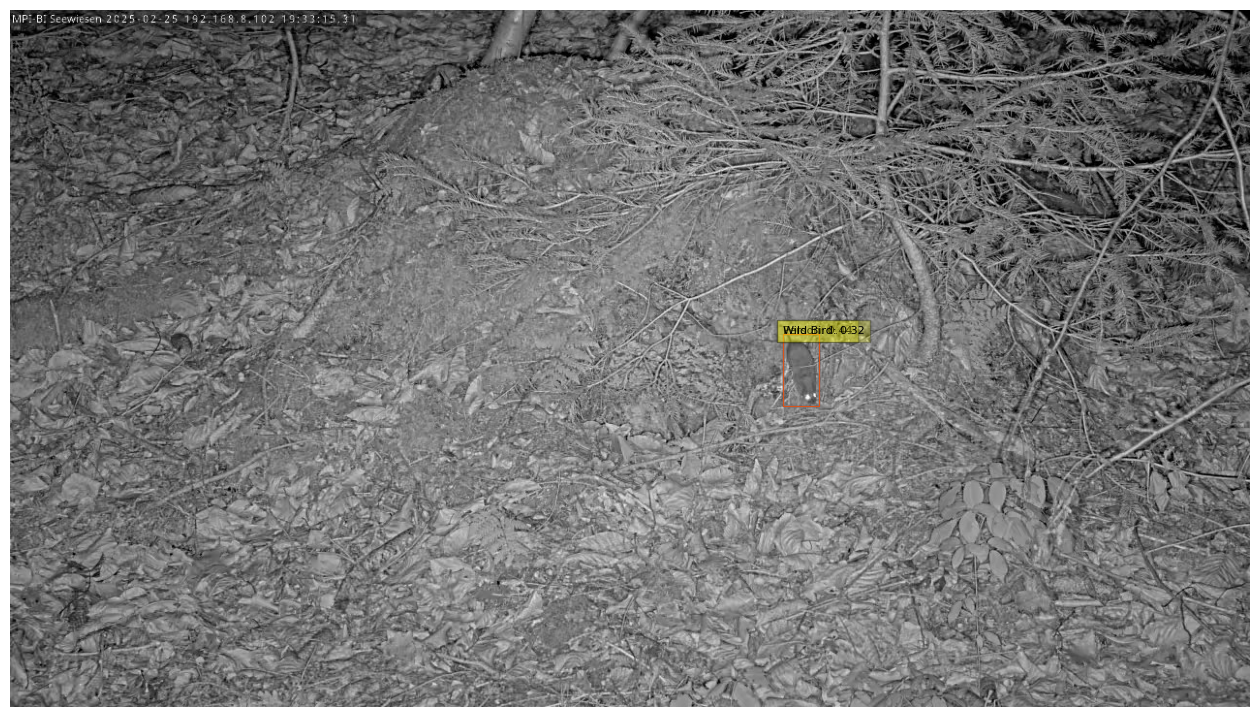

In [ ]:
plot_results(
    pil_image=image,
    scores=image_detections['scores'].tolist(),
    labels=image_detections['labels'].tolist(),
    boxes=image_detections['boxes'].tolist(),
)

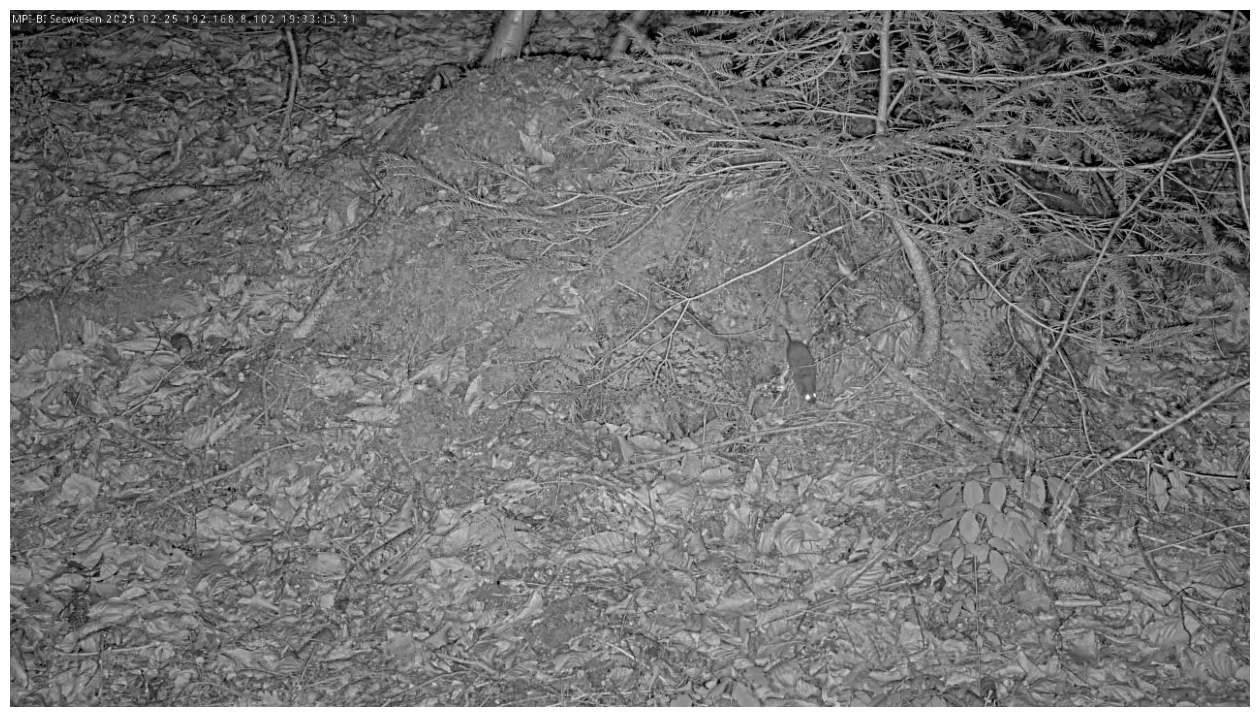

In [ ]:
plot_results(
    pil_image=image,
    scores=image_detections['scores'].tolist(),
    labels=image_detections['labels'].tolist(),
    boxes=image_detections['boxes'].tolist(),
    visible_classes=['Wild Bird']
)

## Pipeline API

Alternatively, if you don't want to implement the pre- and postprocessing yourself, the Transformers library offers the [pipeline abstraction](https://huggingface.co/docs/transformers/en/main_classes/pipelines) which does all of what we did above for you. Usage is really easy:

In [ ]:
from transformers import pipeline

pipe = pipeline("object-detection", model=checkpoint, image_processor=checkpoint)

Device set to use cuda:0


In [ ]:
results = pipe('/content/seewiesen_animal_images/MaG_FieldV5_axisQ8102_2025-02-25_19_33_15_946.jpg', threshold=0.3)

In [ ]:
results

[{'score': 0.4436379373073578,
  'label': 'Person',
  'box': {'xmin': 797, 'ymin': 334, 'xmax': 834, 'ymax': 408}},
 {'score': 0.32391658425331116,
  'label': 'Wild Bird',
  'box': {'xmin': 797, 'ymin': 334, 'xmax': 834, 'ymax': 408}}]

We can visualize the results in a similar way:

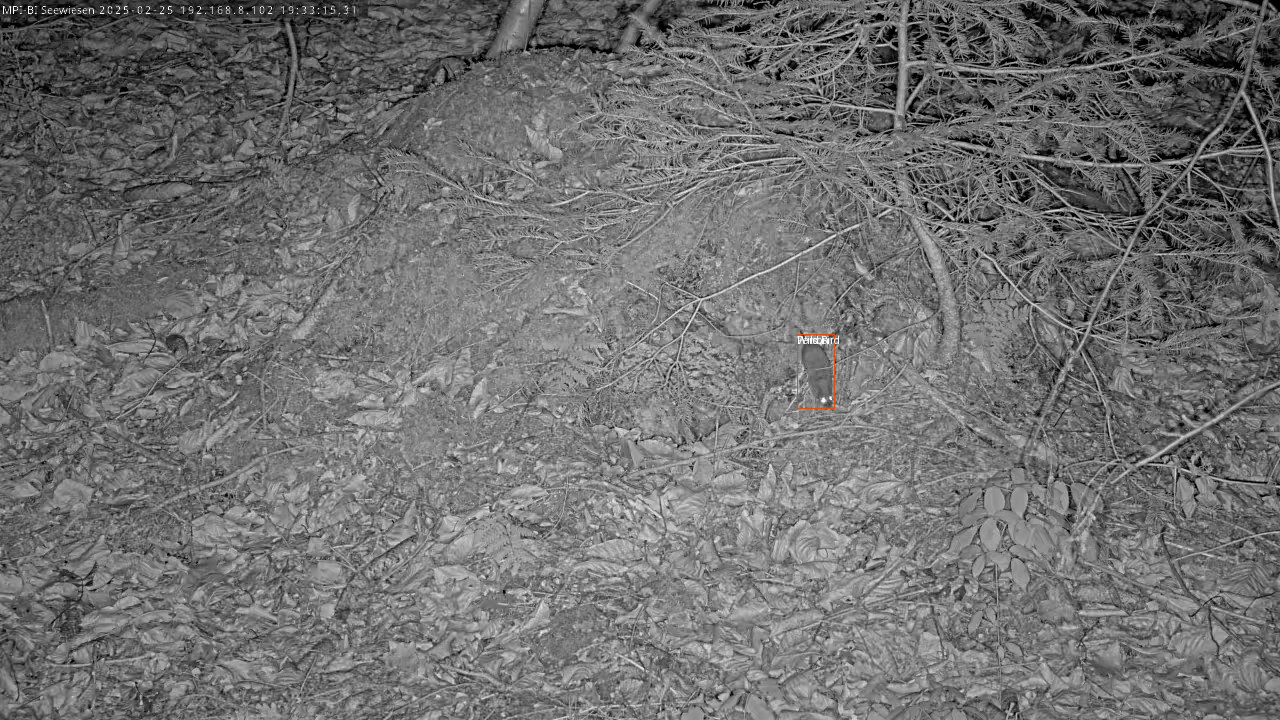

In [ ]:
from PIL import ImageDraw

# visualize
# let's use Pillow's ImageDraw feature

annotated_image = image.copy()
draw = ImageDraw.Draw(annotated_image)

for i, result in enumerate(results):
  box = result["box"]
  color = tuple([int(x * 255) for x in COLORS[i]])
  xmin, ymin, xmax, ymax = box["xmin"], box["ymin"], box["xmax"], box["ymax"]
  draw.rectangle((xmin, ymin, xmax, ymax), fill=None, outline=color, width=1)
  draw.text((xmin, ymin, xmax, ymax), text=result["label"])

annotated_image

#### Visualize results from other checkpoints

ustc-community/dfine-nano-coco


Device set to use cuda


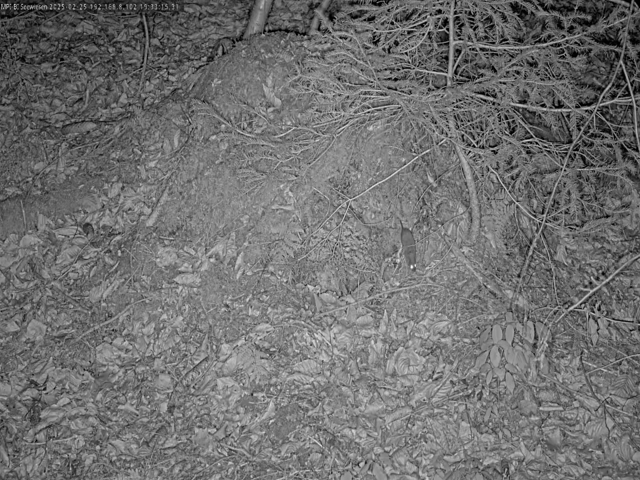

ustc-community/dfine-small-obj365


Device set to use cuda


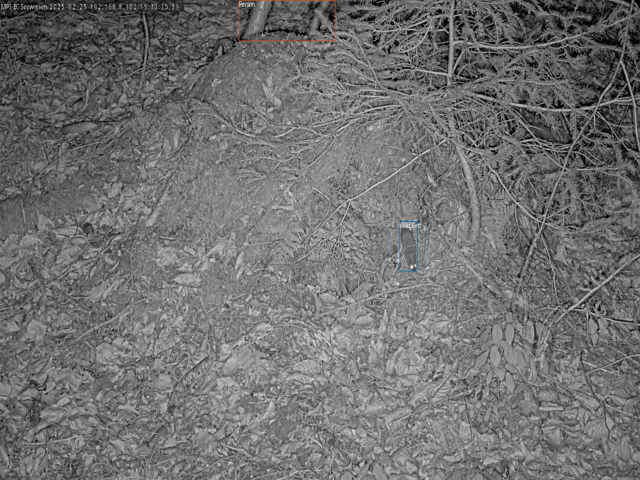

ustc-community/dfine-xlarge-obj365


Device set to use cuda


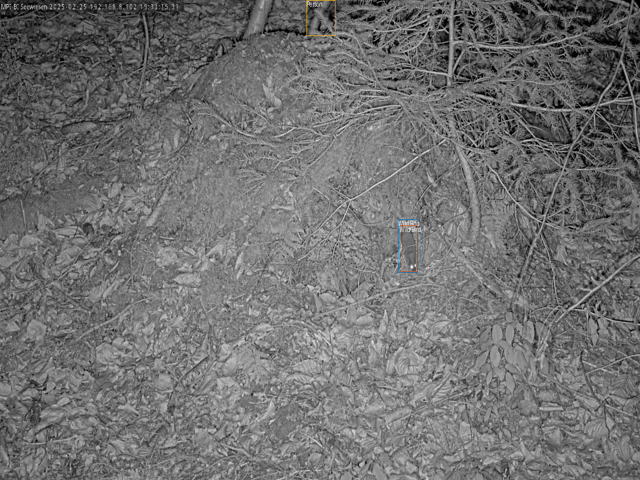

ustc-community/dfine-medium-obj2coco


Device set to use cuda


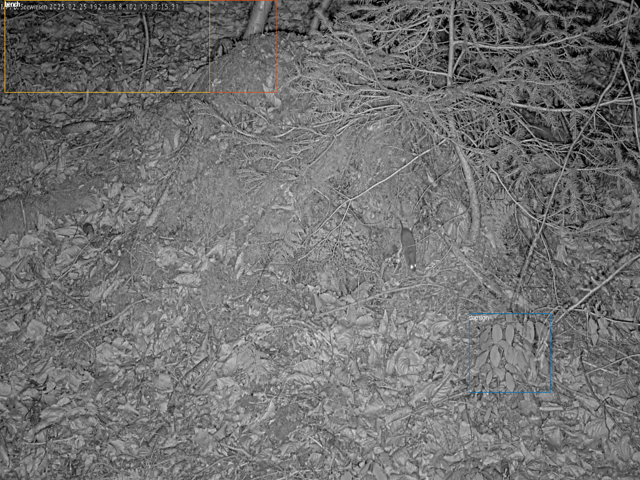

In [ ]:
checkpoints = [
  "ustc-community/dfine-nano-coco",
  "ustc-community/dfine-small-obj365",
  "ustc-community/dfine-xlarge-obj365",
  "ustc-community/dfine-medium-obj2coco",
]

for checkpoint in checkpoints:
  print(checkpoint)
  pipe = pipeline("object-detection", model=checkpoint, image_processor=checkpoint, device=device)
  results = pipe(image, threshold=0.3)

  annotated_image = image.copy()
  draw = ImageDraw.Draw(annotated_image)

  for i, result in enumerate(results):
    box = result["box"]
    color = tuple([int(x * 255) for x in COLORS[i]])
    xmin, ymin, xmax, ymax = box["xmin"], box["ymin"], box["xmax"], box["ymax"]
    draw.rectangle((xmin, ymin, xmax, ymax), fill=None, outline=color, width=1)
    draw.text((xmin, ymin, xmax, ymax), text=result["label"])

  display(annotated_image.resize([640, 480]))